# Testing Binary Structure Models on Multivariate Data

Much of this notebook is adapted from notebooks/bivariate-categorical/03_meta_learning.ipynb

In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange as tnrange

from cs330.data_generators.multivariate_categorical import MultiCategorical
from cs330.data_generators.causal_graph import CausalGraph
from models import StructuralModel

In [3]:
N = 10
model = StructuralModel(N, dtype=torch.float64)

In [4]:
M = 10

In [5]:
# Create a graph and functional model to generate data
data_gen = MultiCategorical(N, M)

In [6]:
# Optionally enforce conditions on graph
if True:
    data_gen.graph.B[-1, -2] = 0

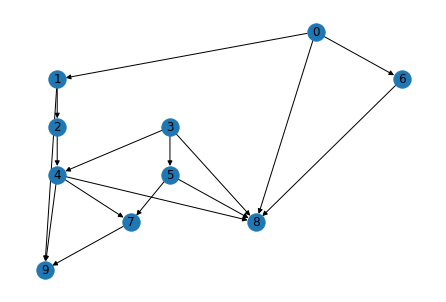

In [7]:
# Visualize graph
data_gen.graph.visualize()

In [44]:
# Determine the two node indices to compare
A = 0
B = 3

In [45]:
inner_lr = 1e-3 #1e-1
outer_lr = 1e-2

optimizer = torch.optim.SGD(model.modules_parameters(), lr=inner_lr)
meta_optimizer = torch.optim.RMSprop([model.w], lr=outer_lr)

In [46]:
num_runs = 1 # 10
num_training = 1 # 100
num_transfer = 500
num_gradient_steps = 20

train_batch_size = 1000
transfer_batch_size = 10

In [47]:
alphas = np.zeros((num_runs, num_training, num_transfer))
inner_log_likelihood_AB = np.zeros((num_runs, num_training, num_transfer, num_gradient_steps + 1))
inner_log_likelihood_BA = np.zeros((num_runs, num_training, num_transfer, num_gradient_steps + 1))

for j in tnrange(num_runs):
    model.w.data.zero_()
    for i in tnrange(num_training, leave=False):
        # Step 1: Sample a joint distribution before intervention
        data_gen.reset_all_distributions()

        # Step 1.5: Compute effective ground truth correlation between chosen nodes
        pi_A_1, pi_B_A = data_gen.compute_correlation(A, B)
        
        transfers = tnrange(num_transfer, leave=False)
        for k in transfers:
            # Step 2: Train the modules on the training distribution
            model.set_ground_truth(pi_A_1, pi_B_A)

            # Step 3: Sample a joint distribution after intervention
            data_gen.reset_root_distributions()

            # Step 3.5: Log first inner training loss
            multivar_onehot_samples = data_gen.sample(transfer_batch_size)
            a_inds = np.argmax(multivar_onehot_samples[:, A, :], axis=-1)
            b_inds = np.argmax(multivar_onehot_samples[:, B, :], axis=-1)
            x_train = np.vstack((a_inds, b_inds)).T.astype(np.int64)
            x_train = torch.from_numpy(x_train)
            with torch.no_grad():
                inner_log_likelihood_AB[j, i, k, 0] = torch.mean(model.model_A_B(x_train)).item()
                inner_log_likelihood_BA[j, i, k, 0] = torch.mean(model.model_B_A(x_train)).item()

            # Step 4: Do k steps of gradient descent for adaptation on the
            # distribution after intervention
            model.zero_grad()
            loss = torch.tensor(0., dtype=torch.float64)
            for g in range(num_gradient_steps):
                multivar_onehot_samples = data_gen.sample(transfer_batch_size)
                a_inds = np.argmax(multivar_onehot_samples[:, A, :], axis=-1)
                b_inds = np.argmax(multivar_onehot_samples[:, B, :], axis=-1)
                x_train = np.vstack((a_inds, b_inds)).T.astype(np.int64)
                x_train = torch.from_numpy(x_train)

                loss += -torch.mean(model(x_train))
                optimizer.zero_grad()
                inner_loss_A_B = -torch.mean(model.model_A_B(x_train))
                inner_loss_B_A = -torch.mean(model.model_B_A(x_train))
                inner_loss = inner_loss_A_B + inner_loss_B_A
                inner_loss.backward()
                optimizer.step()

                # Log inner training loss
                with torch.no_grad():
                    inner_log_likelihood_AB[j, i, k, g + 1] = torch.mean(model.model_A_B(x_train)).item()
                    inner_log_likelihood_BA[j, i, k, g + 1] = torch.mean(model.model_B_A(x_train)).item()


            # Step 5: Update the structural parameter alpha
            meta_optimizer.zero_grad()
            loss.backward()
            meta_optimizer.step()

            # Log the values of alpha
            alpha = torch.sigmoid(model.w).item()
            alphas[j, i, k] = alpha
            transfers.set_postfix(alpha='{0:.4f}'.format(alpha), grad='{0:.4f}'.format(model.w.grad.item()))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

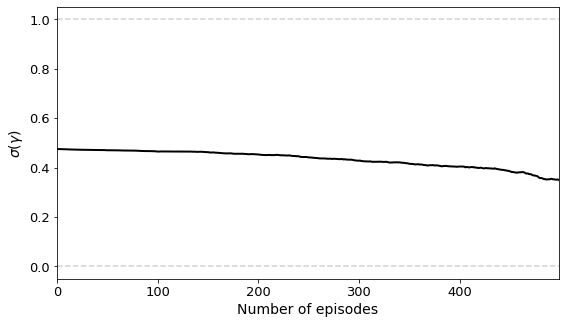

In [48]:
alphas_50 = np.percentile(alphas.reshape((-1, num_transfer)), 50, axis=0)

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
ax.plot(alphas_50, lw=2, color='k')

ax.set_xlim([0, num_transfer - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)

plt.savefig(f"{A}->{B}_alphas.png")
plt.show()

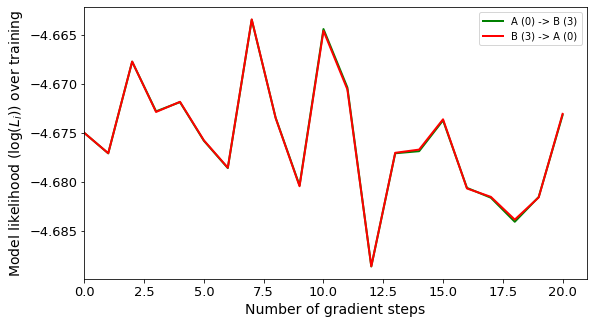

In [49]:
inner_log_likelihood_AB_50 = np.percentile(inner_log_likelihood_AB.reshape(-1, num_gradient_steps + 1), 50, axis=0)
inner_log_likelihood_BA_50 = np.percentile(inner_log_likelihood_BA.reshape(-1, num_gradient_steps + 1), 50, axis=0)
#inner_log_likelihood_AB_50 = np.mean(inner_log_likelihood_AB.reshape(-1, num_gradient_steps + 1), axis=0)
#inner_log_likelihood_BA_50 = np.mean(inner_log_likelihood_BA.reshape(-1, num_gradient_steps + 1), axis=0)


fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.plot(inner_log_likelihood_AB_50, lw=2, color='g', label=f"A -> B ({A} -> {B})")
ax.plot(inner_log_likelihood_BA_50, lw=2, color='r', label=f"B -> A ({B} -> {A})")
ax.legend()

ax.set_xlim([0, num_gradient_steps + 1])
ax.set_xlabel('Number of gradient steps', fontsize=14)
ax.set_ylabel(r'Model likelihood ($\log(L_i)$) over training', fontsize=14)

plt.savefig(f"{A}->{B}_inner_training.png")
plt.show()